In [1]:
!unrar x "/content/drive/MyDrive/DSP/TestSet.rar" "/content/"
!unrar x "/content/drive/MyDrive/DSP/TrainSet.rar" "/content/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal

Enter password (will not be echoed) for /content/drive/MyDrive/DSP/TestSet.rar: 


Extracting from /content/drive/MyDrive/DSP/TestSet.rar

Creating    /content/TestSet                                          OK
Creating    /content/TestSet/0                                        OK
Extracting  /content/TestSet/0/FAG_ZB.08.wav                               0%  OK 
Extracting  /content/TestSet/0/FBI_ZB.08.wav                               0%  OK 
Extracting  /content/TestSet/0/FEE_ZB.08.wav                               1%  OK 
Extracting  /content/TestSet/0/FJJ_ZB.08.wav                               1%  OK 
Extracting  /content/TestSet/0/FJN_ZA.08.wav                               1%  OK 
Extracting  /content/TestSet/0/FJN_ZB.08.wav                               2%  OK 
Extracting  /content/TestSet/0/FKK_ZB.08.wav                               2%  

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import librosa
import librosa.display
import numpy as np
from librosa.util import normalize

In [2]:
import numpy as np
from collections import Counter
class KNN:
    def __init__(self, k=3):
        self.k = k
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [75]:
import numpy as np


class SVM:
    def __init__(self, learning_rate=0.01, reg_strength=0.01, num_iters=10000,degree=1):
        self.learning_rate = learning_rate
        self.reg_strength = reg_strength
        self.num_iters = num_iters
        self.weights = None
        self.bias = None
        self.num_classes = None
        self.degree=degree
    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.num_classes = np.max(y) + 1
        self.weights = np.random.randn(self.num_classes, num_features)
        self.bias = np.zeros(self.num_classes)

        for _ in range(self.num_iters):
            if(self.degree>1):
                scores = (1 + np.dot(X, self.weights.T)) ** self.degree + self.bias
            else:
                scores = np.dot(X, self.weights.T) + self.bias
            correct_class_scores = scores[np.arange(num_samples), y]
            margins = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + 1)
            margins[np.arange(num_samples), y] = 0
            loss = np.sum(margins) / num_samples + 0.5 * self.reg_strength * np.sum(self.weights ** 2)

            margins[margins > 0] = 1
            incorrect_counts = np.sum(margins, axis=1)
            margins[np.arange(num_samples), y] = -incorrect_counts
            dW = np.dot(margins.T, X) / num_samples + self.reg_strength * self.weights
            db = np.sum(margins, axis=0) / num_samples

            self.weights -= self.learning_rate * dW
            self.bias -= self.learning_rate * db

    def predict(self, X):
        if(self.degree>1):
            scores = (1 + np.dot(X, self.weights.T)) ** self.degree + self.bias
        else:
            scores = np.dot(X, self.weights.T) + self.bias
        return np.argmax(scores, axis=1)

In [54]:
data_folder = '/content/TrainSet'
xs_train = []
y_train  = []
for label in range(10):  # assuming folders are labeled from 0 to 10
    folder_path = os.path.join(data_folder, str(label))
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        y, _ = librosa.load(file_path,sr=16000)
        y, _ = librosa.effects.trim(y)  # Remove leading and trailing silence
        y = normalize(y)  # Normalizing the audio signal
        xs_train.append(y)
        y_train.append(label)


data_folder = '/content/TestSet'
xs_test = []
y_test  = []
for label in range(10):  # assuming folders are labeled from 0 to 10
    folder_path = os.path.join(data_folder, str(label))
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        y, _ = librosa.load(file_path,sr=16000)
        y, _ = librosa.effects.trim(y)  # Remove leading and trailing silence
        y = normalize(y)  # Normalizing the audio signal
        xs_test.append(y)
        y_test.append(label)

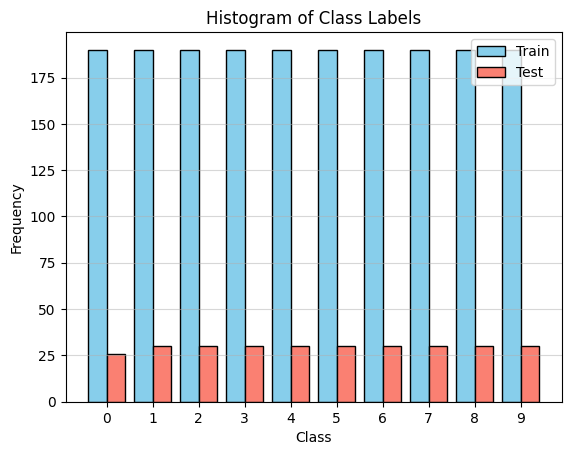

In [55]:
import matplotlib.pyplot as plt
import numpy as np


# Plot histograms for y_train and y_test
plt.hist([y_train, y_test], bins=np.arange(11)-0.5, rwidth=0.8, color=['skyblue', 'salmon'], edgecolor='black', label=['Train', 'Test'])
plt.xticks(range(10))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Class Labels')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


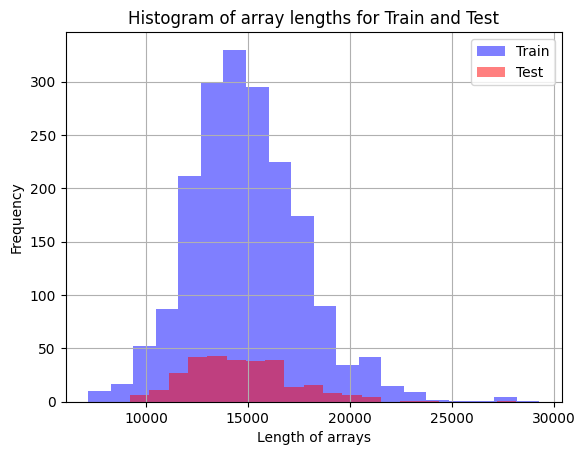

In [56]:
import matplotlib.pyplot as plt

# Assuming ys_train and ys_test are lists of numpy arrays
ys_train_shapes = [arr.shape[0] for arr in xs_train]
ys_test_shapes = [arr.shape[0] for arr in xs_test]

# Plotting histograms
plt.hist(ys_train_shapes, bins=20, color='blue', alpha=0.5, label='Train')
plt.hist(ys_test_shapes, bins=20, color='red', alpha=0.5, label='Test')
plt.xlabel('Length of arrays')
plt.ylabel('Frequency')
plt.title('Histogram of array lengths for Train and Test')
plt.grid(True)
plt.legend()
plt.show()


In [57]:
filtered_xs_train = [arr for arr in xs_train if arr.shape[0] >= 13000 and arr.shape[0] <= 26000]
filtered_ys_train = [y_train[i] for i, arr in enumerate(xs_train) if arr.shape[0] >= 13000 and arr.shape[0] <= 26000]

filtered_xs_test = [arr for arr in xs_test if arr.shape[0] >= 13000 and arr.shape[0] <= 26000]
filtered_ys_test = [y_test[i] for i, arr in enumerate(xs_test) if arr.shape[0] >= 13000 and arr.shape[0] <= 26000]
xs_train=filtered_xs_train
y_train=filtered_ys_train
xs_test=filtered_xs_test
y_test=filtered_ys_test

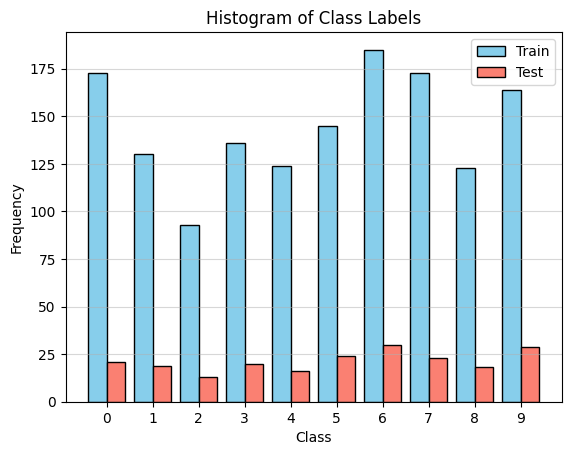

In [58]:
import matplotlib.pyplot as plt
import numpy as np


# Plot histograms for y_train and y_test
plt.hist([y_train, y_test], bins=np.arange(11)-0.5, rwidth=0.8, color=['skyblue', 'salmon'], edgecolor='black', label=['Train', 'Test'])
plt.xticks(range(10))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Class Labels')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


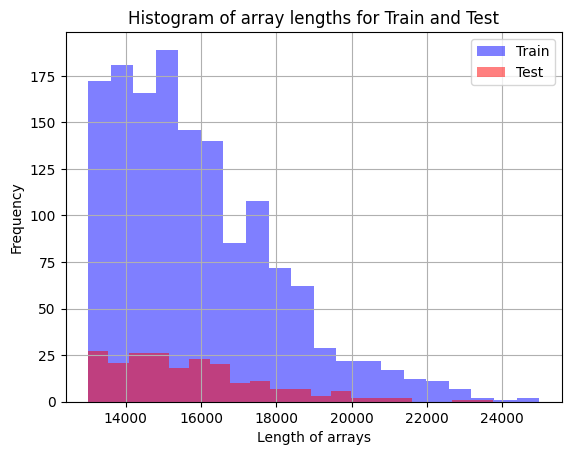

In [59]:
import matplotlib.pyplot as plt

# Assuming ys_train and ys_test are lists of numpy arrays
ys_train_shapes = [arr.shape[0] for arr in xs_train]
ys_test_shapes = [arr.shape[0] for arr in xs_test]

# Plotting histograms
plt.hist(ys_train_shapes, bins=20, color='blue', alpha=0.5, label='Train')
plt.hist(ys_test_shapes, bins=20, color='red', alpha=0.5, label='Test')
plt.xlabel('Length of arrays')
plt.ylabel('Frequency')
plt.title('Histogram of array lengths for Train and Test')
plt.grid(True)
plt.legend()
plt.show()


# MFCC

In [60]:

def extract_mfcc_features(y, sr, max_length):
    frame_length = 0.020
    n_mfcc = 12
    n_mels = 24

    # Calculate the number of samples for the desired frame length
    frame_length_samples = int(sr * frame_length)
    #y_padded=y
    # # Pad the signal to the desired length
    if len(y) < max_length:
        y_padded = librosa.util.pad_center(y, size=max_length)
    else:
        y_padded = y[:max_length]

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y_padded, sr=sr, n_mfcc=n_mfcc, n_mels=n_mels, hop_length=frame_length_samples)
    mfccs_processed = np.mean(mfcc.T,axis=0) # take mean of MFCCs along the time axis
    delta1_mfcc = librosa.feature.delta(mfcc, order=1)
    delta1_mfcc_processed = np.mean(delta1_mfcc.T,axis=0)

    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    delta2_mfcc_processed = np.mean(delta2_mfcc.T,axis=0)

    mfcc_features = np.concatenate((mfccs_processed, delta1_mfcc_processed, delta2_mfcc_processed), axis=0)
    return mfcc_features

In [61]:

max_length = max(max(xs_train, key=lambda x: x.shape[0]).shape[0] , max(xs_test, key=lambda x: x.shape[0]).shape[0] )
X_train_mfcc = []
for x in xs_train:
    features = extract_mfcc_features(x, 16000, max_length)
    X_train_mfcc.append(features)

X_test_mfcc = []
for x in xs_test:
    features = extract_mfcc_features(x, 16000, max_length)
    X_test_mfcc.append(features)

In [62]:
from sklearn.preprocessing import StandardScaler

X_train_mfcc = np.array(X_train_mfcc)
y_train = np.array(y_train)
X_test_mfcc = np.array(X_test_mfcc)
y_test = np.array(y_test)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_mfcc_scaled = scaler.fit_transform(X_train_mfcc)
X_test_mfcc_scaled = scaler.transform(X_test_mfcc)


## KNN from Scratch

Accuracy for the test set with k=5: 0.6384976525821596
Accuracy for the test set with k=7: 0.6713615023474179
Accuracy for the test set with k=11: 0.6948356807511737
Accuracy for the test set with k=15: 0.704225352112676
Accuracy for the test set with k=20: 0.6807511737089202
Mean accuracy: 0.6779342723004694


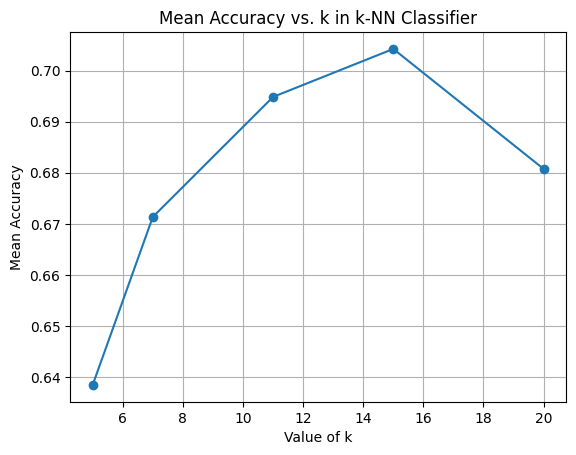

In [63]:

# Initialize k-NN classifier
Ks=[5,7,11,15,20]
accuracies=[]
for k in Ks:
    knn = KNN(k=k)

    # Train the k-NN classifier
    knn.fit(X_train_mfcc_scaled, y_train)

    # Predict on the test data
    y_pred = knn.predict(X_test_mfcc_scaled)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for the test set with k={k}: {accuracy}")
    accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy: {mean_accuracy}")

# Plot the mean accuracy for each value of k
plt.plot(Ks, accuracies, marker='o')
plt.title('Mean Accuracy vs. k in k-NN Classifier')
plt.xlabel('Value of k')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

## KNN Library

Accuracy for the test set with k=5: 0.6103286384976526
Accuracy for the test set with k=7: 0.6431924882629108
Accuracy for the test set with k=11: 0.6619718309859155
Accuracy for the test set with k=15: 0.6854460093896714
Accuracy for the test set with k=20: 0.6807511737089202
Mean accuracy: 0.6563380281690142


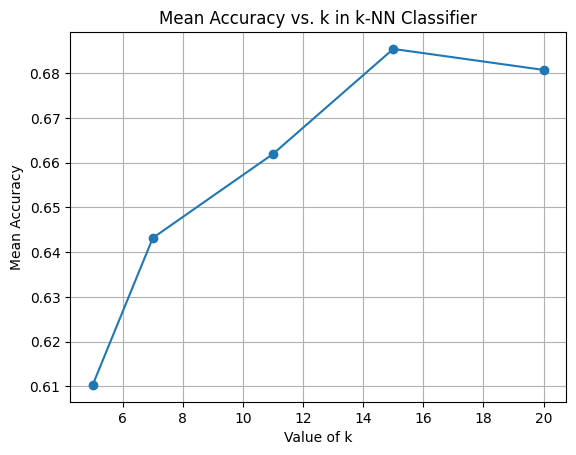

In [64]:

# Initialize k-NN classifier
Ks=[5,7,11,15,20]
accuracies=[]
for k in Ks:
  knn = KNeighborsClassifier(n_neighbors=k)

  # Train the k-NN classifier
  knn.fit(X_train_mfcc_scaled, y_train)

  # Predict on the test data
  y_pred = knn.predict(X_test_mfcc_scaled)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for the test set with k={k}: {accuracy}")
  accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy: {mean_accuracy}")

# Plot the mean accuracy for each value of k
plt.plot(Ks, accuracies, marker='o')
plt.title('Mean Accuracy vs. k in k-NN Classifier')
plt.xlabel('Value of k')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

## SVM from Scratch

### SVM Linear


In [76]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVM()

# Train the SVM classifier
svm.fit(X_train_mfcc_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_mfcc_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.6666666666666666


### SVM Poly


In [78]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVM(degree=5)

# Train the SVM classifier
svm.fit(X_train_mfcc_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_mfcc_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.6103286384976526


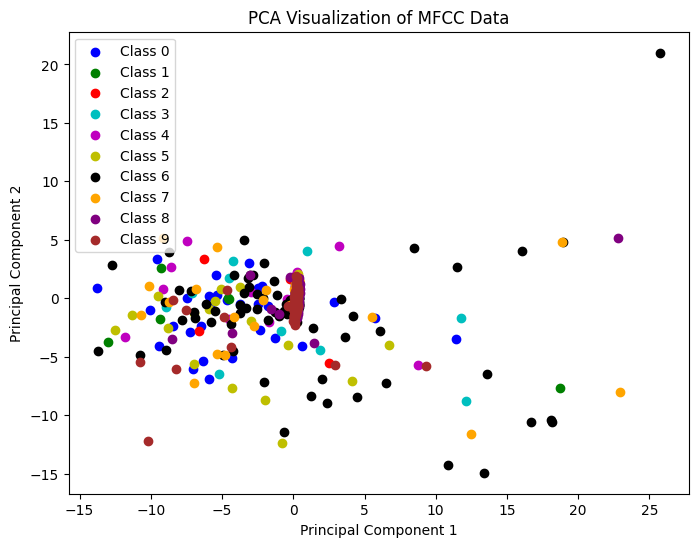

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)
X_train_mfcc_pca = pca.fit_transform(X_train_mfcc_scaled)

# Visualize PCA
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']  # Different colors for each class
for i in range(10):  # Assuming you have 10 classes
    plt.scatter(X_train_mfcc_pca[y_train == i, 0], X_train_mfcc_pca[y_train == i, 1], label=f'Class {i}', color=colors[i])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of MFCC Data')
plt.legend()
plt.show()


## SVM Library

### SVM Linear


In [67]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVC(kernel='linear')

# Train the SVM classifier
svm.fit(X_train_mfcc_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_mfcc_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.676056338028169


### SVM Poly


In [82]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVC(kernel='poly', degree=2)

# Train the SVM classifier
svm.fit(X_train_mfcc_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_mfcc_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.5586854460093896


# B) LPC

In [83]:
def extract_LPC_features(y):
    LPC = librosa.lpc(y=y, order=13)
    return LPC

In [84]:

X_train_LPC = []
for x in xs_train:
    features = extract_LPC_features(x)
    X_train_LPC.append(features)

X_test_LPC = []
for x in xs_test:
    features = extract_LPC_features(x)
    X_test_LPC.append(features)

X_train_LPC = np.array(X_train_LPC)
X_test_LPC = np.array(X_test_LPC)
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_LPC_scaled = scaler.fit_transform(X_train_LPC)
X_test_LPC_scaled = scaler.transform(X_test_LPC)

## KNN from Scratch

Accuracy for the test set with k=5: 0.14084507042253522
Accuracy for the test set with k=7: 0.1267605633802817
Accuracy for the test set with k=11: 0.14553990610328638
Accuracy for the test set with k=15: 0.13145539906103287
Accuracy for the test set with k=20: 0.1267605633802817
Mean accuracy: 0.13427230046948355


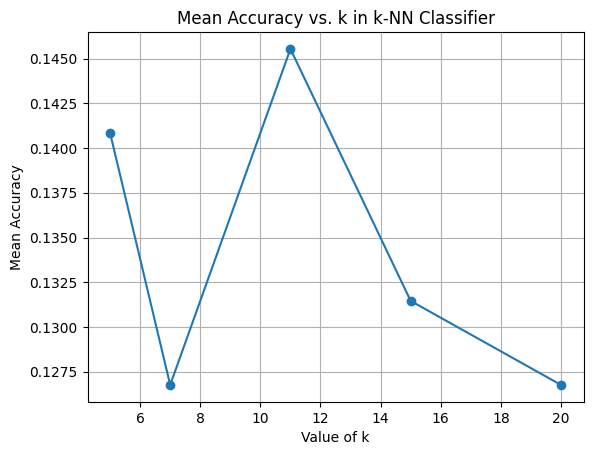

In [85]:

Ks=[5,7,11,15,20]
accuracies=[]
for k in Ks:
  knn = KNN(k=k)

  # Train the k-NN classifier
  knn.fit(X_train_LPC_scaled, y_train)

  # Predict on the test data
  y_pred = knn.predict(X_test_LPC_scaled)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for the test set with k={k}: {accuracy}")
  accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy: {mean_accuracy}")

# Plot the mean accuracy for each value of k
plt.plot(Ks, accuracies, marker='o')
plt.title('Mean Accuracy vs. k in k-NN Classifier')
plt.xlabel('Value of k')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

## KNN Library

Accuracy for the test set with k=5: 0.14084507042253522
Accuracy for the test set with k=7: 0.12206572769953052
Accuracy for the test set with k=11: 0.15023474178403756
Accuracy for the test set with k=15: 0.1267605633802817
Accuracy for the test set with k=20: 0.11737089201877934
Mean accuracy: 0.13145539906103287


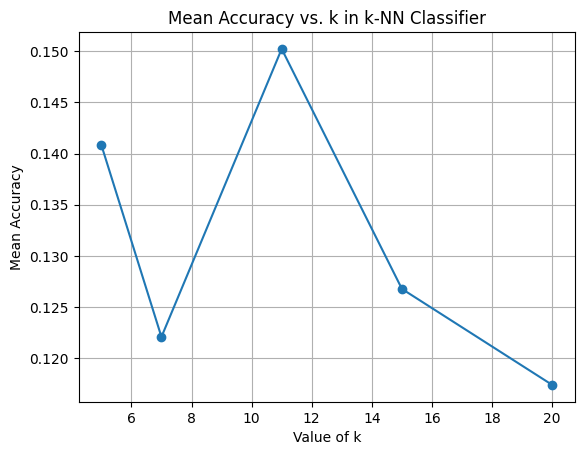

In [86]:

Ks=[5,7,11,15,20]
accuracies=[]
for k in Ks:
  knn = KNeighborsClassifier(n_neighbors=k)

  # Train the k-NN classifier
  knn.fit(X_train_LPC_scaled, y_train)

  # Predict on the test data
  y_pred = knn.predict(X_test_LPC_scaled)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for the test set with k={k}: {accuracy}")
  accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy: {mean_accuracy}")

# Plot the mean accuracy for each value of k
plt.plot(Ks, accuracies, marker='o')
plt.title('Mean Accuracy vs. k in k-NN Classifier')
plt.xlabel('Value of k')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

## SVM form Scratch

### SVM Linear


In [87]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVM()

# Train the SVM classifier
svm.fit(X_train_LPC_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_LPC_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.12206572769953052


### SVM Poly


In [88]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVM(degree=2)

# Train the SVM classifier
svm.fit(X_train_LPC_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_LPC_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.12206572769953052


## SVM Library

### SVM Linear


In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVC(kernel='linear', max_iter=1000)

# Train the SVM classifier
svm.fit(X_train_LPC_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_LPC_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.14084507042253522


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### SVM Poly

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVC(kernel='poly', degree=10, max_iter=1000)

# Train the SVM classifier
svm.fit(X_train_LPC_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_LPC_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.14084507042253522


# Concantaned feauters [MFCC;LPC]

In [28]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Concatenate the feature sets
X_train_combined = np.concatenate((X_train_mfcc, X_train_LPC), axis=1)
X_test_combined = np.concatenate((X_test_mfcc, X_test_LPC), axis=1)

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_combined_scaled = scaler.transform(X_test_combined)

## KNN from Scratch

Accuracy for the test set with k=5: 0.6338028169014085
Accuracy for the test set with k=7: 0.6713615023474179
Accuracy for the test set with k=11: 0.6901408450704225
Accuracy for the test set with k=15: 0.6995305164319249
Accuracy for the test set with k=20: 0.6854460093896714
Mean accuracy: 0.6760563380281691


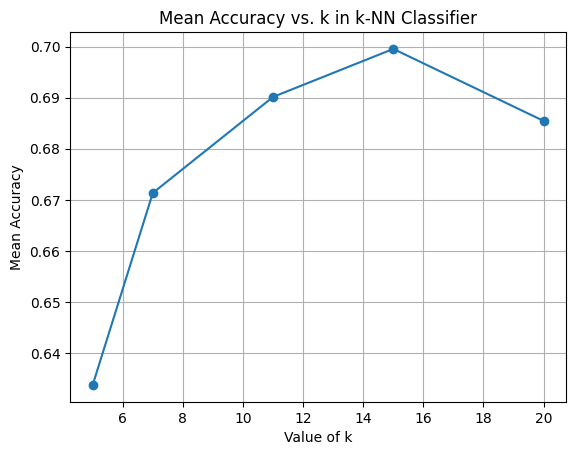

In [29]:

Ks=[5,7,11,15,20]
accuracies=[]
for k in Ks:
  knn = KNN(k=k)

  # Train the k-NN classifier
  knn.fit(X_train_combined_scaled , y_train)

  # Predict on the test data
  y_pred = knn.predict(X_test_combined_scaled )

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for the test set with k={k}: {accuracy}")
  accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy: {mean_accuracy}")

# Plot the mean accuracy for each value of k
plt.plot(Ks, accuracies, marker='o')
plt.title('Mean Accuracy vs. k in k-NN Classifier')
plt.xlabel('Value of k')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

## KNN Library

Accuracy for the test set with k=5: 0.6056338028169014
Accuracy for the test set with k=7: 0.6431924882629108
Accuracy for the test set with k=11: 0.6525821596244131
Accuracy for the test set with k=15: 0.6901408450704225
Accuracy for the test set with k=20: 0.6807511737089202
Mean accuracy: 0.6544600938967136


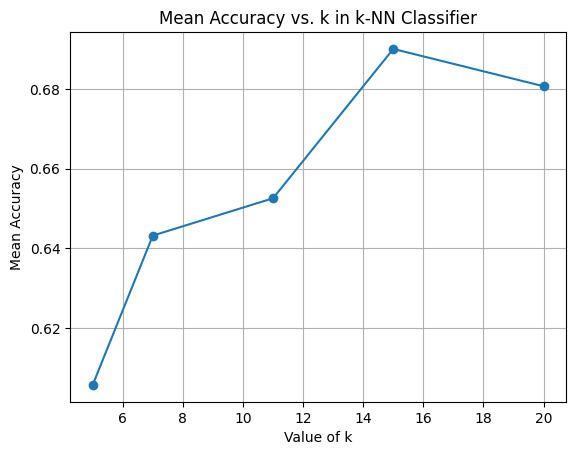

In [30]:
Ks=[5,7,11,15,20]
accuracies=[]
for k in Ks:
  knn = KNeighborsClassifier(n_neighbors=k)

  # Train the k-NN classifier
  knn.fit(X_train_combined_scaled , y_train)

  # Predict on the test data
  y_pred = knn.predict(X_test_combined_scaled )

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for the test set with k={k}: {accuracy}")
  accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy: {mean_accuracy}")

# Plot the mean accuracy for each value of k
plt.plot(Ks, accuracies, marker='o')
plt.title('Mean Accuracy vs. k in k-NN Classifier')
plt.xlabel('Value of k')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

## SVM form Scratch

### SVM Linear


In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVM()

# Train the SVM classifier
svm.fit(X_train_combined_scaled , y_train)

# Predict on the test data
y_pred = svm.predict(X_test_combined_scaled )

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.6056338028169014


### SVM Poly


In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVM(degree=2)

# Train the SVM classifier
svm.fit(X_train_combined_scaled , y_train)

# Predict on the test data
y_pred = svm.predict(X_test_combined_scaled )

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.45539906103286387


## SVM Library

### SVM Lieanr

In [33]:

# Initialize the SVM classifier
svm = SVC(kernel='linear', max_iter=1000)

# Train the SVM classifier
svm.fit(X_train_combined_scaled , y_train)

# Predict on the test data
y_pred_combined = svm.predict(X_test_combined_scaled )

# Evaluate the model
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"Accuracy for the test set with combined features: {accuracy_combined}")


Accuracy for the test set with combined features: 0.6666666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Poly

In [89]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVC(kernel='poly', degree=2, max_iter=10000)

# Train the SVM classifier
svm.fit(X_train_combined_scaled , y_train)

# Predict on the test data
y_pred = svm.predict(X_test_combined_scaled )

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.4225352112676056


# Concantaned feauters + Zero Crossing



In [35]:
def extract_zr_features(y):
    zcr = librosa.feature.zero_crossing_rate(y)
    mean_zcr = np.mean(zcr)
    return mean_zcr

In [36]:

max_length = max(max(xs_train, key=lambda x: x.shape[0]).shape[0] , max(xs_test, key=lambda x: x.shape[0]).shape[0] )
X_train_zcr = []
for x in xs_train:
    features = extract_zr_features(x)
    X_train_zcr.append(features)

X_test_zcr = []
for x in xs_test:
    features = extract_zr_features(x)
    X_test_zcr.append(features)

X_train_zcr = np.array(X_train_zcr)
X_test_zcr = np.array(X_test_zcr)

X_train_zcr = X_train_zcr.reshape(-1, 1)
X_test_zcr = X_test_zcr.reshape(-1, 1)



In [37]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train_combined_zcr = np.concatenate((X_train_mfcc , X_train_LPC , X_train_zcr), axis=1)
X_test_combined_zcr = np.concatenate((X_test_mfcc, X_test_LPC,X_test_zcr), axis=1)


# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_combined_zcr_scaled = scaler.fit_transform(X_train_combined_zcr)
X_test_combined_zcr_scaled = scaler.transform(X_test_combined_zcr)


## KNN from Scratch

Accuracy for the test set with k=5: 0.6525821596244131
Accuracy for the test set with k=7: 0.6713615023474179
Accuracy for the test set with k=11: 0.6854460093896714
Accuracy for the test set with k=15: 0.676056338028169
Accuracy for the test set with k=20: 0.676056338028169
Mean accuracy: 0.6723004694835681


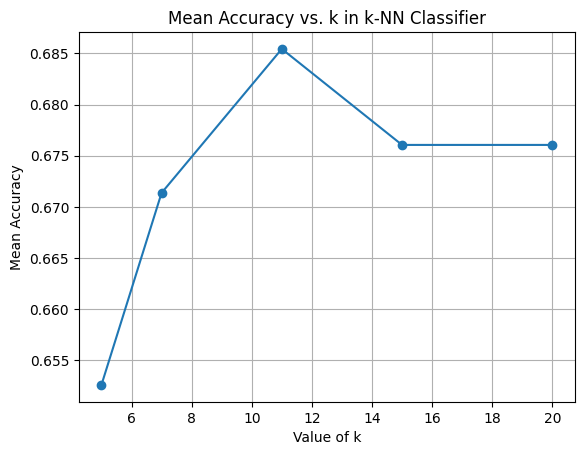

In [38]:

Ks=[5,7,11,15,20]
accuracies=[]
for k in Ks:
  knn = KNN(k=k)

  # Train the k-NN classifier
  knn.fit(X_train_combined_zcr_scaled, y_train)

  # Predict on the test data
  y_pred = knn.predict(X_test_combined_zcr_scaled)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for the test set with k={k}: {accuracy}")
  accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy: {mean_accuracy}")

# Plot the mean accuracy for each value of k
plt.plot(Ks, accuracies, marker='o')
plt.title('Mean Accuracy vs. k in k-NN Classifier')
plt.xlabel('Value of k')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

## KNN Library

Accuracy for the test set with k=5: 0.6150234741784038
Accuracy for the test set with k=7: 0.647887323943662
Accuracy for the test set with k=11: 0.676056338028169
Accuracy for the test set with k=15: 0.6666666666666666
Accuracy for the test set with k=20: 0.6619718309859155
Mean accuracy: 0.6535211267605634


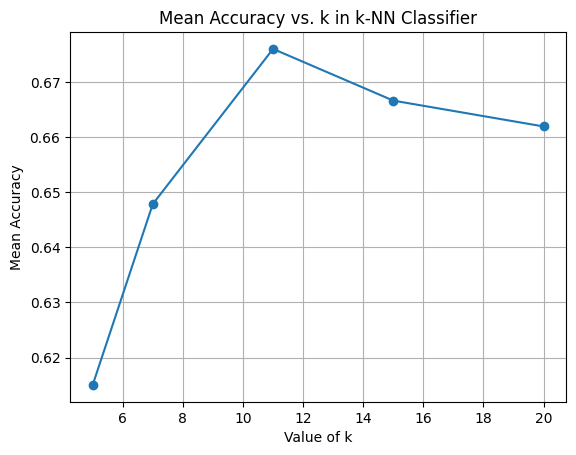

In [39]:

Ks=[5,7,11,15,20]
accuracies=[]
for k in Ks:
  knn = KNeighborsClassifier(n_neighbors=k)

  # Train the k-NN classifier
  knn.fit(X_train_combined_zcr_scaled, y_train)

  # Predict on the test data
  y_pred = knn.predict(X_test_combined_zcr_scaled)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for the test set with k={k}: {accuracy}")
  accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy: {mean_accuracy}")

# Plot the mean accuracy for each value of k
plt.plot(Ks, accuracies, marker='o')
plt.title('Mean Accuracy vs. k in k-NN Classifier')
plt.xlabel('Value of k')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

## SVM form Scratch

### SVM Linear


In [40]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVM()

# Train the SVM classifier
svm.fit(X_train_combined_zcr_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_combined_zcr_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.5868544600938967


### SVM Poly


In [41]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVM(degree=3)

# Train the SVM classifier
svm.fit(X_train_combined_zcr_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_combined_zcr_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.5586854460093896


## SVM Library

### SVM Lieanr

In [42]:

# Initialize the SVM classifier
svm = SVC(kernel='linear', max_iter=1000)

# Train the SVM classifier
svm.fit(X_train_combined_zcr_scaled, y_train)

# Predict on the test data
y_pred_combined = svm.predict(X_test_combined_zcr_scaled)

# Evaluate the model
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"Accuracy for the test set with combined features: {accuracy_combined}")


Accuracy for the test set with combined features: 0.6901408450704225


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Poly

In [90]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with linear kernel
svm = SVC(kernel='poly', degree=2, max_iter=1000)

# Train the SVM classifier
svm.fit(X_train_combined_zcr_scaled, y_train)

# Predict on the test data
y_pred = svm.predict(X_test_combined_zcr_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for the test set with SVM linear kernel: {accuracy}")

Accuracy for the test set with SVM linear kernel: 0.4507042253521127
